<h1 align="center">Emotion Detection using FER Dataset </h1>

<strong>Emotion Recognition</strong> has been widely employed by big firms to understand people behaviour of their product by understanding how they react to their advertisements. Some film companies are taking advantage of emotion detection software and are using it to determine how moviegoers are enjoying their films. They do this by letting the software capture people’s faces and track facial behavior using infrared cameras during movie screenings.

 In this project we will be determining the emotions of persons using facial Expressions using Computer Vision and DeepLearning techniques. We will be building our model on <b>Tensorflow with keras</b> background. We will be using the <i><b>Kaggle's FER2013 dataset</b></i> to train and test our models. Dataset can be downloaded <a href="https://www.kaggle.com/deadskull7/fer2013">here</a>
 
 <font size=3>We will also be impementing real time face detection and emotion recognition using our trained model at the end of this project</font>
 

## Importing necessary Libraries

In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import pandas as pd

In [2]:
print(tf.__version__)

2.1.0


## Dataset Preprocessing

Our Dataset consists of two columns "pixels" and "emotion". Pixels column consists of string of 2304 integers seperated by spaces. These represent the image array in one dimension. We will be converting this column into a 3d image array of (48,48,3) using the <i><font color=blue size=3>convert_to_image</font></i> method. Emotion column consists of facial expressions across 7 categories
<font color=blue size=3>['Angry','Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']</font>

In [3]:

NUM_CLASSES = 7 #['Angry','Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
IMG_ROWS, IMG_COLS = 48, 48

In [14]:
# method to convert 1D pixel array to 3D grayscale image

def convert_to_image(pixels):
  image_array = []
  for pixel in pixels:
    pixel = np.array([int(i) for i in pixel.split()])
    pixel = pixel.reshape(IMG_ROWS,IMG_COLS)
    image3D = np.empty((IMG_ROWS, IMG_COLS, 3))
    image3D[:, :, 0] = pixel
    image3D[:, :, 1] = pixel
    image3D[:, :, 2] = pixel
    image_array.append(image3D)
  image_array = np.array(image_array)
  return image_array

In [15]:
#Split Dataset to train and validation set

train_dataset = pd.read_csv('train.csv')
test_dataset = pd.read_csv('test.csv')

train_pixels = convert_to_image(train_dataset.loc[:,'pixels'])
train_emotions = train_dataset.loc[:,'emotion']

emotion_values = ['Angry','Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [6]:
#splitting up the dataset to train and validation sets

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_pixels, train_emotions, test_size=0.3,
                                                  shuffle=True, random_state=0)

# change labels to categorical
#from tensorflow.keras.utils import np_utils
y_train = tf.keras.utils.to_categorical(y_train,num_classes=NUM_CLASSES,dtype='int64')
y_val = tf.keras.utils.to_categorical(y_val,num_classes=NUM_CLASSES,dtype='int64')

In [7]:
#visualising shape of each train and validation data

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(20096, 48, 48, 3)
(8613, 48, 48, 3)
(20096, 7)
(8613, 7)


In [8]:
BATCH_SIZE = 128

Training deep learning neural network models on more data can result in more skillful models, and the augmentation techniques can create variations of the images that can improve the ability of the fit models to generalize what they have learned to new images. You can refer more about Image Augmentation <a href="https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/">here</a>

In [9]:
#Image Augmentation using ImageDataGenerator

image_gen_train = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

image_gen_val = ImageDataGenerator(rescale=1./255)

train_gen = image_gen_train.flow(X_train,y_train,batch_size=BATCH_SIZE)
val_gen = image_gen_val.flow(X_val,y_val,batch_size=BATCH_SIZE)

In [10]:
# Function for visualizing images

def plotImages(images_arr,total_images=5):
    fig, axes = plt.subplots(1, int(total_images), figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

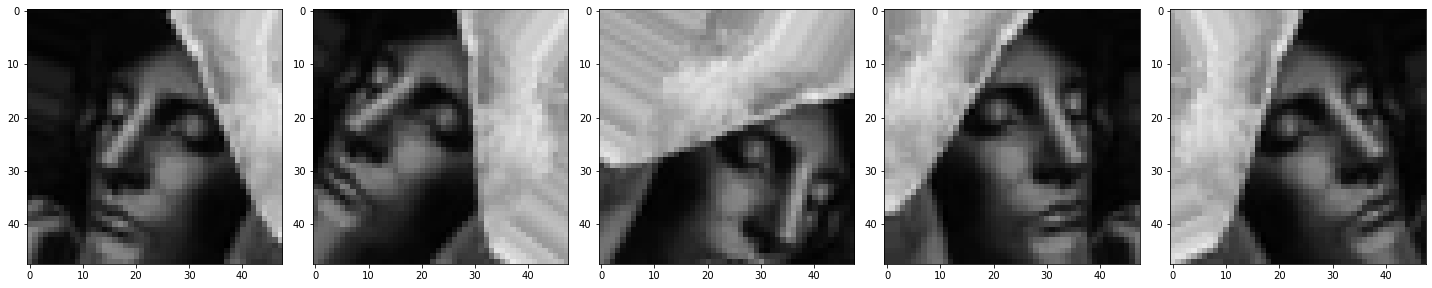

In [11]:
# Visualising augmented images

augmented_images = [train_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

## Creating the Model

We will create a model similar to VGG16 architecture. Refer about VGG16 architecture <a href="https://engmrk.com/vgg16-implementation-using-keras/">here</a>

In [12]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Dense,Flatten
from tensorflow.keras.activations import relu,softmax

model = Sequential()

model.add(Conv2D(32,(3,3),activation=relu,padding='same', input_shape=(IMG_ROWS,IMG_COLS,3)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64,(3,3),activation=relu, padding='same'))
model.add(MaxPooling2D(2,2))

model.add(Dropout(0.5))

model.add(Conv2D(128, (3,3), activation=relu, padding='same'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(256, (3,3), activation=relu, padding='same'))
model.add(MaxPooling2D(2,2))

model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128,activation=relu))
model.add(Dense(256,activation=relu))
model.add(Dense(7,activation=softmax))

from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(),
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# Early stopping to stop model training if model validation loss perfomance does not improve
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)

#Storing best weights
filepath="weights.best.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', 
                                                verbose=1, save_best_only=True, mode='max')

In [ ]:
#Training the model

EPOCHS = 100
CALLBACKS = [es,checkpoint]
hist_withAugment_FER = model.fit(train_gen, steps_per_epoch=X_train.shape[0] // BATCH_SIZE, 
                                 epochs=EPOCHS, verbose=1,validation_data=val_gen, 
                                 validation_steps=X_val.shape[0] // BATCH_SIZE,
                                 callbacks=CALLBACKS)
model.save('emotions_detection_FER_100.h5')

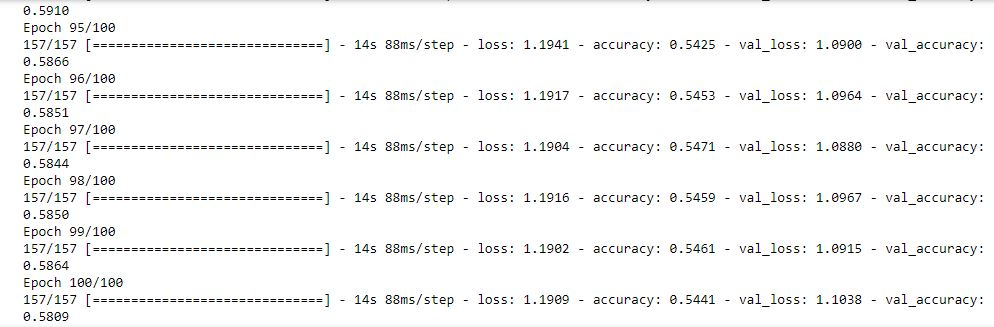

Our Model reached an accuracy of <strong>58%</strong>. You can also tweak the model parameters such as changing the learning rate additional convolutional layers to the model similar to a VGG or Resnet architecture. 

In [0]:
# method to Plot Training and Validation Accuracies and losses

def plot_Accuracy_Loss(hist):
  %matplotlib inline

  train_loss=hist.history['loss']
  val_loss=hist.history['val_loss']
  train_acc=hist.history['accuracy']
  val_acc=hist.history['val_accuracy']

  epochs = range(len(train_acc))

  plt.plot(epochs,train_loss,'r', label='train_loss')
  plt.plot(epochs,val_loss,'b', label='val_loss')
  plt.title('train_loss vs val_loss')
  plt.legend()
  plt.figure()

  plt.plot(epochs,train_acc,'r', label='train_acc')
  plt.plot(epochs,val_acc,'b', label='val_acc')
  plt.title('train_acc vs val_acc')
  plt.legend()
  plt.figure()

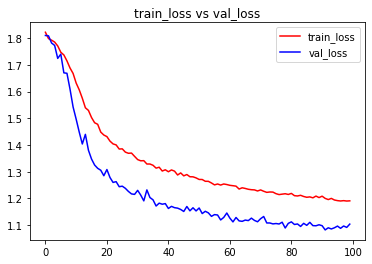

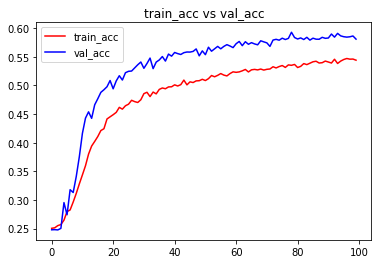

<Figure size 432x288 with 0 Axes>

In [22]:
plot_Accuracy_Loss(hist_withAugment_FER)

You can notice a strange thing here. Validation loss is less than that of training one. For beginners this may be a strange thing. Here we attach a <a href="https://www.pyimagesearch.com/2019/10/14/why-is-my-validation-loss-lower-than-my-training-loss/">link</a> to <font color=blue size=3>PyImageSearch</font> website where the Computer Vision Expert <font color=blue size=3>Adrian Rosebrock</font> gives you a deep insight about why this happens

## Testing the Model with test set

In [26]:
# visualizing first 36 images of test set

def visualizePredictions(test_images):
  #change the PATH to where your saved model is present
  PATH = "E:\Kaggle Datasets\FER\emotions_detection_FER_100.h5"
    
  model = tf.keras.models.load_model(PATH)  
  res = model.predict(test_images)

  fig = plt.figure(figsize=(10, 10))
  for i in range(0, len(res)):
      fig.add_subplot(6,6,i+1)
      plt.imshow(test_images[i],cmap=plt.get_cmap('gray'))
      plt.gca().get_xaxis().set_ticks([])
      plt.gca().get_yaxis().set_ticks([])
      plt.ylabel('prediction = %s' % emotion_values[np.argmax(res[i])], fontsize=8)
  # show the plot
  plt.show()

In [27]:
# method to convert images compatible to be fed into the model for prediction
def image2Vector(images):
  test=[]
  for image in images:
    image = cv2.resize(image,(IMG_ROWS,IMG_COLS))
    image = tf.cast(image, tf.float32)
    image /= 255
    image = image.numpy()
    test.append(image)
  test = np.array(test)
  return test

In [28]:
def predict_FER_images(test_data):
  test_pixels = []
  for pixel in test_data:
    pixel = np.array([int(i) for i in pixel.split()])
    pixel = pixel.reshape(IMG_ROWS,IMG_COLS)
    out = np.empty((IMG_ROWS, IMG_COLS, 3))
    out[:, :, 0] = pixel
    out[:, :, 1] = pixel
    out[:, :, 2] = pixel
    test_pixels.append(out)
  test_pixels = np.array(test_pixels)
  return image2Vector(test_pixels)

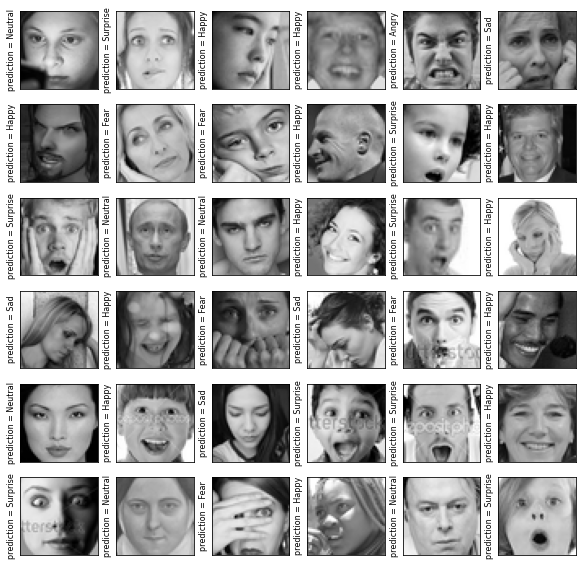

In [19]:
# predicting the test set

test_images = predict_FER_images(test_dataset.iloc[36:72,0])
visualizePredictions(test_images)

In [ ]:
#Incase you need to test your model on your own custom Images. You can use the code below

imgs = []
test_dir = "" #Path of the folder where your images are placed
for pic in os.listdir(test_dir):
  im = cv2.imread(os.path.join(test_dir,pic))
  imgs.append(im)

test_images = image2Vector(imgs[:36])
visualizePredictions(test_images)

## Emotion Recognition From Live video

Here we will test our model on live video using Laptop camera of any other camera of your preference (Appropriately change the VideoCapture input) and obtain live face image from camera using <font color=blue size=3>Haarcascade</font> and applying our model to detect emotions. Haarcascade frontalface default can be obtained <a href="https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml">here</a>

In [29]:
#change HARSCASCADE to where your haarcascade frontal face xml model is saved
HARSCASCADE = r"E:\Anaconda3\envs\UnchartedTech\Library\etc\haarcascades\haarcascade_frontalface_default.xml"

faceCascade = cv2.CascadeClassifier(HARSCASCADE)
def face_detector(img):
    # Convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray, 1.3, 5)
    if faces is ():
        return (0,0,0,0), np.zeros((IMG_ROWS,IMG_COLS), np.uint8), img
    
    #Bounding box for face
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        
    #return face image if present else return an empty array
    try:
        roi_gray = cv2.resize(roi_gray, (IMG_ROWS, IMG_COLS), 
                              interpolation = cv2.INTER_AREA)
        out = np.empty((IMG_ROWS, IMG_COLS, 3))
        out[:, :, 0] = roi_gray
        out[:, :, 1] = roi_gray
        out[:, :, 2] = roi_gray
    except:
        return (x,w,y,h), np.zeros((IMG_ROWS,IMG_COLS), np.uint8), img
    return (x,w,y,h), out, img

In [31]:
from tensorflow.keras.preprocessing.image import img_to_array

#change MODEL_PATH to your saved model
MODEL_PATH = "E:\Kaggle Datasets\FER\emotions_detection_FER_100.h5"

classifier = tf.keras.models.load_model(MODEL_PATH)
emotion_values = ['Angry','Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

cap = cv2.VideoCapture(0)

while True:

    ret, frame = cap.read()
    rect, face, image = face_detector(frame)
    if np.sum([face]) != 0.0:
        roi = face.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)

        # make a prediction on the ROI, then lookup the class
        preds = classifier.predict(roi)
        label = emotion_values[np.argmax(preds)]  
        label_position = (rect[0] + int((rect[1]/2)), rect[2] + 25)
        cv2.putText(image, label, label_position , cv2.FONT_HERSHEY_SIMPLEX,
                    2, (0,255,0), 3)
    else:
        cv2.putText(image, "No Face Found", (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,
                    2, (0,255,0), 3)
        
    cv2.imshow('All', image)
    key = cv2.waitKey(1) & 0xFF
    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
      break
        
cap.release()
cv2.destroyAllWindows()